# Analysing Characteristics of an entire PageXML Archive

**Note**: This tutorial follows and depends on the tutorial on [Reading PageXML files from archives](./Demo-reading-pagexml-files-from-archive.ipynb). It assumes you have downloaded the PageXML archives and derived line format files from them. 

This tutorials shows how you can analyse the layout and text of sets of PageXML files.

As an example of a zipped archive, this tutorial uses two datasets provided by the [National Archives of the Netherlands](https://www.nationaalarchief.nl/en) (NA) via their HTR repository on [Zenodo](https://zenodo.org/): https://zenodo.org/record/6414086#.Y8Elk-zMIUo. The repository contains many other HTR PageXML datasets that NA made available.

The datasets contains HTR output in [PageXML](https://www.primaresearch.org/tools/PAGELibraries) format of scans from the following archive: 
- (small) _Notaris mr. D.A.M.de Fremery te Assen, 1899-1915, 114.11, 1_ ([EAD](https://www.drentsarchief.nl/onderzoeken/archiefstukken?mivast=34&mizig=210&miadt=34&micode=0114.11&miview=inv2)). This is an archive maintained by the [Drents Archief](https://www.drentsarchief.nl).
- (medium) _Verspreide West-Indische stukken, 1614-1875, 1.05.06, 1-1413_ ([EAD](https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/%401?query=1.05.06&search-type=inventory)). This is an archive maintained by the [Nationaal Archief](https://www.nationaalarchief.nl/en). 

You can download the datasets via the following URLs:
- https://zenodo.org/record/6414086/files/HTR%20results%20DA%200114.11%20PAGE.zip?download=1
- https://zenodo.org/record/6414086/files/HTR%20results%201.05.06%20PAGE.zip?download=1


In [1]:
%reload_ext autoreload
%autoreload 2


## Extracting PageXML files from Zip/Tar files

The example zip files contains of smaller zip files, that each have a number of PageXML files. 

In [18]:
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pagexml.analysis.stats import get_doc_stats
from pagexml.helper.file_helper import read_page_archive_files
from pagexml.parser import parse_pagexml_files_from_archive

sns.set_theme()

da_archive_file = '../data/HTR results DA 0114.11 PAGE.zip'
na_archive_file = '../data/HTR results 1.05.06 PAGE.zip'

parse_pagexml_files_from_archive(na_archive_file)


<generator object parse_pagexml_files_from_archive at 0x291485000>

# Analysing documents based on layout

## Categorising lines by their widths

Lines can vary strongly in how much text they contain, from one or a few characters to a dozen or more words. How much text they contain and how large the characters are, are related to a line's width. 

The distribution of the width of text lines can tell us whether most lines are roughly of similar length, of whether there are different clusters of line widths. Based on these _line width_ clusters, we can cluster scans based on their distribution of line widths, which can help us identify different types of scans. 

We start with an analysis of the distribution of line widths. Scans often have a width of several thousand pixels, with individual characters taking up somewhere between 15 and 150 pixels. 

In [15]:
sns.set_theme()


In [3]:
%%time
import seaborn as sns

import pagexml.analysis.layout_stats as layout_stats
from pagexml.parser import parse_pagexml_files_from_archive
from pagexml.helper.text_helper import read_pagexml_docs_from_line_file

sns.set_theme()

da_line_file = '../data/line_format-NL-AsnDA_0114.11.tsv.gz'
na_line_file = '../data/line_format-NL-HaNA_1.05.06.tsv.gz'

# reading from line file is much faster 
# than reading from archived PageXML files
scans = read_pagexml_docs_from_line_file(na_line_file, add_bounding_box=True)


line_bin_size = 100
line_widths = layout_stats.get_line_widths(scans, line_bin_size)
print(f'Number of lines: {len(line_widths)}')

Number of lines: 1007175
CPU times: user 17.4 s, sys: 107 ms, total: 17.6 s
Wall time: 17.6 s


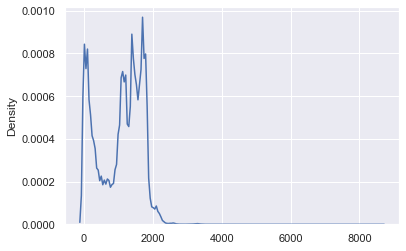

In [16]:
sns.kdeplot(data=line_widths);

We can use the local maxima as centroids of clusters of lines with similar width, and the local minima as boundary points between these clusters. That way, we can categorise the lines of a scan according to these clusters and get summary statistics per scan on the categories of line widths.

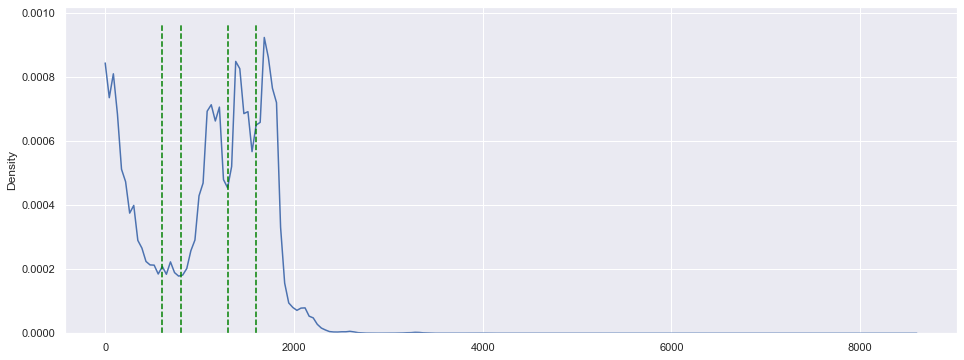

In [17]:
from demo_scripts import plot_line_widths_boundary_points

boundary_points = layout_stats.find_line_width_boundary_points(line_widths, line_bin_size)

plot_line_widths_boundary_points(line_widths, boundary_points)

The distribution has several peaks and valleys. The valleys can be used as boundary points between categories of lines.

# Collecting document statistics

It's simple to get some statistics on the text on a scan using the `.stats` property. But this is very minimal. 

In [6]:
scans = parse_pagexml_files_from_archive(na_archive_file)

for si, scan in enumerate(scans):
    print(scan.id, scan.stats)
    if (si+1) > 5:
        break

NL-HaNA_1.05.06_1_0001.jpg {'lines': 33, 'words': 165, 'text_regions': 1, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0002.jpg {'lines': 59, 'words': 286, 'text_regions': 2, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0003.jpg {'lines': 54, 'words': 263, 'text_regions': 2, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0004.jpg {'lines': 0, 'words': 0, 'text_regions': 0, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_1_0005.jpg {'lines': 0, 'words': 0, 'text_regions': 0, 'columns': 0, 'extra': 0, 'pages': 0}
NL-HaNA_1.05.06_10_0001.jpg {'lines': 34, 'words': 254, 'text_regions': 2, 'columns': 0, 'extra': 0, 'pages': 0}


## Gathering descriptive statistics per scan

The `pagexml.analysis.stats` module contains a function called `get_doc_stats` that gives a richer set of statistics. You can pass it a set of scans (as an iterable, so it can also be an iterable that reads scans from file) to calculate basic statistics per scan, such as:

- the number of lines and words,
- the nubmer of lines of different line width categories,
- the number of words that start with an uppercase character,
- the number of words that are numbers,
- the number of words binned by their lengths.

These allow simple analysis of sequences of scans and cluster of scans based on these characteristics. This is a low-resource approach to clustering and classifying documents. 

**Note**: don't use line-format files for gathering statistics per scan, because line-format files only capture scans that contain at least one text line. **In other words, empty scans are not in the line-format files, and therefore will not be represented in scan statistics!**

In [7]:
import pagexml.analysis.text_stats as text_stats

scans = parse_pagexml_files_from_archive(na_archive_file)

scans_stats = []

scans_stats = get_doc_stats(scans, line_width_boundary_points=boundary_points)
  

The statistics are best viewed and analysed using Pandas.

In [8]:
import pandas as pd

df = pd.DataFrame(scans_stats)

print(df.shape)

df.head(5)

(15857, 39)


,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,59,17,0,0,0,4,0,2,0,27
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,134,17,0,0,0,3,0,0,2,54
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,103,26,0,0,0,2,0,4,1,47
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


If you already have written the statistics to file (or downloaded the file from elsewhere), you can skip the steps above and load them from file.

In [ ]:
stats_file = '../data/na_scan_stats.tsv.gz'

df = pd.read_csv(stats_file, sep='\t', compression='gzip')

## Grouping scans by inventory

The archive contains 15,857 scans belonging to 533 inventories. We use the document identifier to add information per scan on the inventory number and the sequence number of the scan in the inventory's list of scans.

Once we have added this inventory and sequence information, we can:

- group scans by inventory and compare inventories on aggregate statistics,
- visualise characteristics of scans per inventory in sequence order.

In [9]:
df['archive_id'] = df.doc_id.apply(lambda x: x.split('_')[1])
df['inv_num'] = df.doc_id.apply(lambda x: x.split('_')[2])
df['scan_num'] = df.doc_id.apply(lambda x: int(x.split('_')[3].replace('.jpg', '')))
s_inv_nums = df.inv_num.value_counts()
df['num_scans'] = df.inv_num.apply(lambda x: s_inv_nums.loc[x])
df = df.sort_values(['inv_num', 'scan_num'])
df

,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,archive_id,inv_num,scan_num,num_scans
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,0,4,0,2,0,27,1.05.06,1,1,5
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,0,3,0,0,2,54,1.05.06,1,2,5
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,0,2,0,4,1,47,1.05.06,1,3,5
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,4,5
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,NL-HaNA_1.05.06_99_0036.jpg,15853,5103,4067,46,265,3,0,0,0,...,0,6,0,3,1,35,1.05.06,99,36,40
15853,NL-HaNA_1.05.06_99_0037.jpg,15854,5125,4065,44,297,3,0,0,0,...,0,4,0,1,0,39,1.05.06,99,37,40
15854,NL-HaNA_1.05.06_99_0038.jpg,15855,5116,4104,44,290,3,0,0,0,...,0,4,1,4,2,33,1.05.06,99,38,40
15855,NL-HaNA_1.05.06_99_0039.jpg,15856,5111,4054,44,252,3,0,0,0,...,0,7,3,3,1,30,1.05.06,99,39,40


In [10]:
df.head(10)

,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,archive_id,inv_num,scan_num,num_scans
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,0,4,0,2,0,27,1.05.06,1,1,5
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,0,3,0,0,2,54,1.05.06,1,2,5
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,0,2,0,4,1,47,1.05.06,1,3,5
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,4,5
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,0,0,0,0,1.05.06,1,5,5
5,NL-HaNA_1.05.06_10_0001.jpg,6,2622,4011,34,254,2,0,0,0,...,0,1,1,4,1,26,1.05.06,10,1,53
6,NL-HaNA_1.05.06_10_0002.jpg,7,5135,4010,67,519,3,0,0,0,...,0,4,0,1,3,58,1.05.06,10,2,53
7,NL-HaNA_1.05.06_10_0003.jpg,8,5141,4008,70,546,4,0,0,0,...,0,6,0,0,0,62,1.05.06,10,3,53
8,NL-HaNA_1.05.06_10_0004.jpg,9,5140,4010,70,559,2,0,0,0,...,0,5,0,0,1,63,1.05.06,10,4,53
9,NL-HaNA_1.05.06_10_0005.jpg,10,5137,4007,71,548,3,0,0,0,...,0,5,0,2,0,64,1.05.06,10,5,53


The number of scans per inventory is a heavily skewed distribution. Most inventories have only a handful of scans.

### Viewing scans

Because the scans of this archive are also viewable online, we can make visual checks of scans. The scan identifier allows us to construct a viewer URL:

In [11]:
# https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0001?eadID=1.05.06&unitID=1&query=1.05.06
def make_iiif_url(row):
    base_url = 'https://www.nationaalarchief.nl/onderzoeken/archief'
    return f"{base_url}/{row['archive_id']}/invnr/{row['inv_num']}/file/{row['doc_id'][:-4]}?eadId={row['archive_id']}&unitID={row['inv_num']}"


def make_clickable(val):
    return f'<a target="_blank" href="{val}">{val}</a>'



df['iiif_url'] = df.apply(lambda row: make_iiif_url(row), axis=1)
df[['doc_id', 'iiif_url']].head(10).style.format({'iiif_url': make_clickable})


,doc_id,iiif_url
0,NL-HaNA_1.05.06_1_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0001?eadId=1.05.06&unitID=1
1,NL-HaNA_1.05.06_1_0002.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0002?eadId=1.05.06&unitID=1
2,NL-HaNA_1.05.06_1_0003.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0003?eadId=1.05.06&unitID=1
3,NL-HaNA_1.05.06_1_0004.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0004?eadId=1.05.06&unitID=1
4,NL-HaNA_1.05.06_1_0005.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0005?eadId=1.05.06&unitID=1
5,NL-HaNA_1.05.06_10_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0001?eadId=1.05.06&unitID=10
6,NL-HaNA_1.05.06_10_0002.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0002?eadId=1.05.06&unitID=10
7,NL-HaNA_1.05.06_10_0003.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0003?eadId=1.05.06&unitID=10
8,NL-HaNA_1.05.06_10_0004.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0004?eadId=1.05.06&unitID=10
9,NL-HaNA_1.05.06_10_0005.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0005?eadId=1.05.06&unitID=10


### Writing stats to file

Now that statistics of more than 14,000 scans have been calculated and various columns have been added, it is worthwhile writing the statistics to file, so they can be re-used in other analyses, e.g.:

- [book section detection](./Demo-analysing-scan-characteristics-book-sections.ipynb)
- [comparing subsets](./Demo-analysing-scan-characteristics-comparing-subsets.ipynb)
- [checking quality](./Demo-analysing-scan-characteristics-checking-quality.ipynb)


In [12]:
stats_file = '../data/na_scan_stats.tsv.gz'

df.to_csv(stats_file, sep='\t', compression='gzip', index=False)

## Comparing size and shape of scans

### Width and height of scans

To get an idea of how homogeneous or heterogeneous the scans are in terms of shape, we can plot the distribution of scan widths and heights.

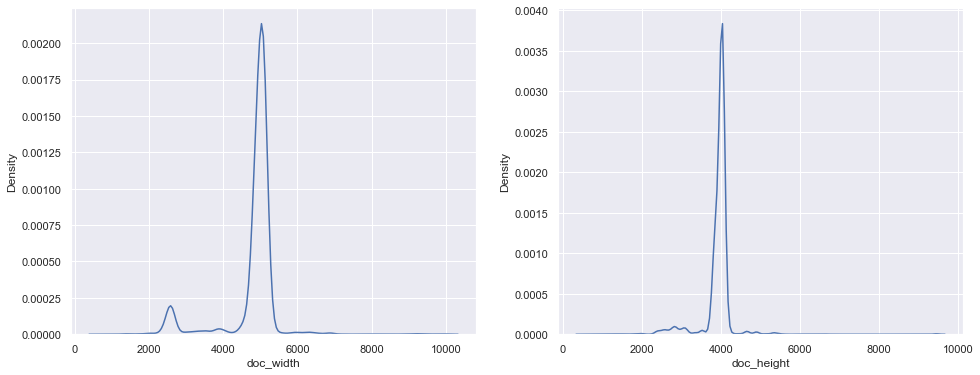

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

sns.kdeplot(data=df.doc_width, ax=ax[0]);
sns.kdeplot(data=df.doc_height, ax=ax[1]);
fig.set_size_inches(16, 6)

In [20]:
import numpy as np

df.doc_width.value_counts()
data = ax[0].lines[0].get_xydata()
peak_width = data[np.where(data[:, 1] == max(data[:, 1]))][0][0]
data = ax[1].lines[0].get_xydata()
peak_height = data[np.where(data[:, 1] == max(data[:, 1]))][0][0]
peak_width, peak_height

(5030.511794106549, 4044.1712745763934)

The vast majority of scans are roughly the same shape, with a width around 5000 pixels and a height around 4000 pixels. There are a few bumps at other widths and heights.

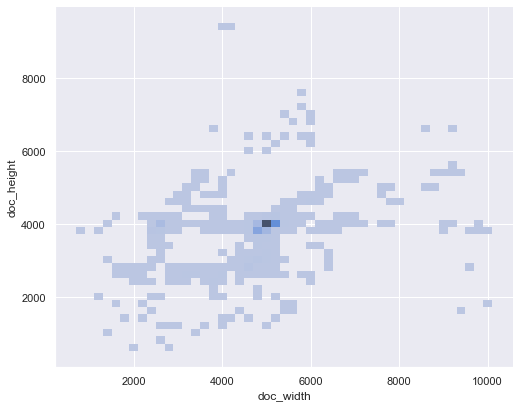

In [21]:
ax = sns.displot(data=df, x='doc_width', y='doc_height', binwidth=(200, 200));
ax.figure.set_size_inches(8, 6)

There seem to be some small clusters of pages with different sizes:

- smaller documents with both a lower width and height than 5000 by 4000
- bigger documents with both a higher width and height than 5000 by 4000
- wider and narrower documents with a height around 4000 but lower or higher width than 5000

If we plot the ratio of width to height, we can see the distribution of scans that are roughly shaped as _landscape_, _portrait_ or _square_.

### Shape of scans

<Axes: ylabel='Density'>

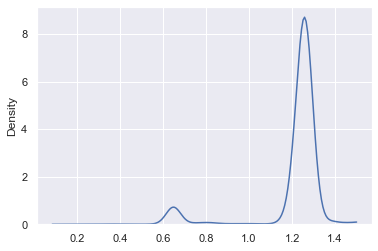

In [22]:
sns.kdeplot(data=df.doc_width.div(df.doc_height, axis=0), clip=(0,1.5))

We use this information to classify scan shape and scan sizes.

### Classifying scans by shape, width and height

In [23]:
def classify_scan_width(width, peak_width):
    if width / peak_width < 0.9:
        return 'narrow'
    elif width / peak_width > 1.1:
        return 'wide'
    else:
        return 'medium'


def classify_scan_height(height, peak_height):
    if height / peak_height < 0.9:
        return 'high'
    elif height / peak_height > 1.1:
        return 'low'
    else:
        return 'medium'


def classify_scan_shape(row):
    if row['doc_width'] / row['doc_height'] > 1.1:
        return 'landscape'
    if row['doc_width'] / row['doc_height'] < 0.9:
        return 'portrait'
    else:
        return 'square'
    
df['shape_class'] = df.apply(classify_scan_shape, axis=1)
df['width_class'] = df.doc_width.apply(lambda width: classify_scan_width(width, peak_width))
df['height_class'] = df.doc_height.apply(lambda height: classify_scan_width(height, peak_height))

df

,doc_id,doc_num,doc_width,doc_height,lines,words,text_regions,columns,extra,pages,...,line_width_range_1300-1600,line_width_range_1600-,archive_id,inv_num,scan_num,num_scans,iiif_url,shape_class,width_class,height_class
0,NL-HaNA_1.05.06_1_0001.jpg,1,2522,3957,33,165,1,0,0,0,...,0,27,1.05.06,1,1,5,https://www.nationaalarchief.nl/onderzoeken/ar...,portrait,narrow,medium
1,NL-HaNA_1.05.06_1_0002.jpg,2,4861,3963,59,286,2,0,0,0,...,2,54,1.05.06,1,2,5,https://www.nationaalarchief.nl/onderzoeken/ar...,landscape,medium,medium
2,NL-HaNA_1.05.06_1_0003.jpg,3,4886,3960,54,263,2,0,0,0,...,1,47,1.05.06,1,3,5,https://www.nationaalarchief.nl/onderzoeken/ar...,landscape,medium,medium
3,NL-HaNA_1.05.06_1_0004.jpg,4,4882,3955,0,0,0,0,0,0,...,0,0,1.05.06,1,4,5,https://www.nationaalarchief.nl/onderzoeken/ar...,landscape,medium,medium
4,NL-HaNA_1.05.06_1_0005.jpg,5,2493,3964,0,0,0,0,0,0,...,0,0,1.05.06,1,5,5,https://www.nationaalarchief.nl/onderzoeken/ar...,portrait,narrow,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,NL-HaNA_1.05.06_99_0036.jpg,15853,5103,4067,46,265,3,0,0,0,...,1,35,1.05.06,99,36,40,https://www.nationaalarchief.nl/onderzoeken/ar...,landscape,medium,medium
15853,NL-HaNA_1.05.06_99_0037.jpg,15854,5125,4065,44,297,3,0,0,0,...,0,39,1.05.06,99,37,40,https://www.nationaalarchief.nl/onderzoeken/ar...,landscape,medium,medium
15854,NL-HaNA_1.05.06_99_0038.jpg,15855,5116,4104,44,290,3,0,0,0,...,2,33,1.05.06,99,38,40,https://www.nationaalarchief.nl/onderzoeken/ar...,landscape,medium,medium
15855,NL-HaNA_1.05.06_99_0039.jpg,15856,5111,4054,44,252,3,0,0,0,...,1,30,1.05.06,99,39,40,https://www.nationaalarchief.nl/onderzoeken/ar...,landscape,medium,medium


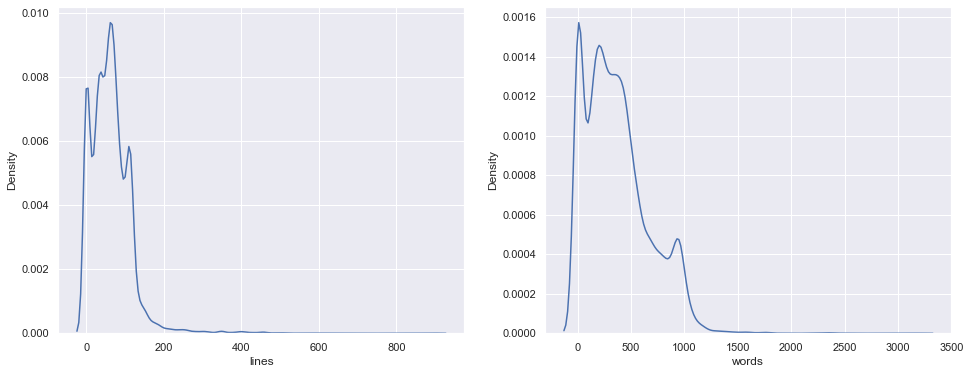

In [24]:
fig, ax = plt.subplots(1, 2)

sns.kdeplot(data=df.lines, ax=ax[0]);
sns.kdeplot(data=df.words, ax=ax[1]);
fig.set_size_inches(16, 6)

### Comparing scans of different shapes

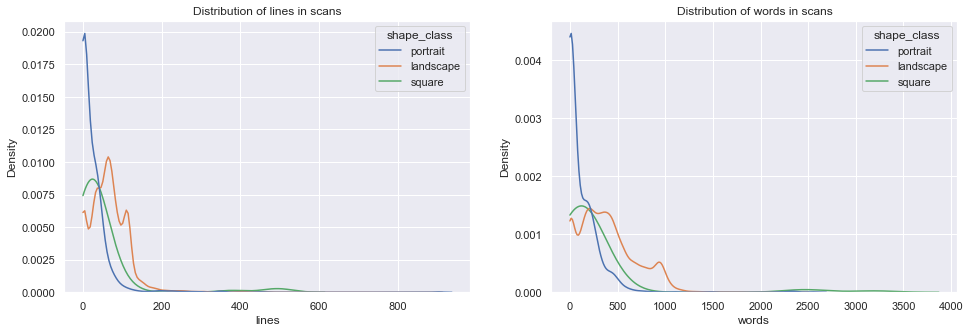

In [25]:
portrait = df[df.shape_class == 'portrait']
landscape = df[df.shape_class == 'landscape']
square = df[df.shape_class == 'square']

fig, ax = plt.subplots(1, 2)

clip_words = (0, 4000)
clip_lines = (0, 1000)

sns.kdeplot(data=df, x='lines', hue='shape_class', common_norm=False, clip=clip_lines, ax=ax[0]);
sns.kdeplot(data=df, x='words', hue='shape_class', common_norm=False, clip=clip_words, ax=ax[1]);

ax[0].set_title('Distribution of lines in scans')
ax[1].set_title('Distribution of words in scans')


fig.set_size_inches(16, 5)

## Analysing scans with many lines and many words

### Scans with high numbers of lines

In [26]:
# sort scans by descending number of lines and show shape information and a clickable viewer URL
(df.sort_values('lines', ascending=False)
 .head(10)[['doc_id', 'lines', 'doc_width', 'doc_height', 'width_class', 'height_class', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,lines,doc_width,doc_height,width_class,height_class,iiif_url
12420,NL-HaNA_1.05.06_709_0006.jpg,904,5165,6145,medium,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/709/file/NL-HaNA_1.05.06_709_0006?eadId=1.05.06&unitID=709
7000,NL-HaNA_1.05.06_176_0002.jpg,890,9934,3844,wide,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/176/file/NL-HaNA_1.05.06_176_0002?eadId=1.05.06&unitID=176
6999,NL-HaNA_1.05.06_176_0001.jpg,788,9705,3864,wide,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/176/file/NL-HaNA_1.05.06_176_0001?eadId=1.05.06&unitID=176
7091,NL-HaNA_1.05.06_186_0015.jpg,704,7857,4948,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/186/file/NL-HaNA_1.05.06_186_0015?eadId=1.05.06&unitID=186
2168,NL-HaNA_1.05.06_117_0043.jpg,690,5026,4010,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/117/file/NL-HaNA_1.05.06_117_0043?eadId=1.05.06&unitID=117
7253,NL-HaNA_1.05.06_220_0005.jpg,660,5102,4085,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/220/file/NL-HaNA_1.05.06_220_0005?eadId=1.05.06&unitID=220
1310,NL-HaNA_1.05.06_1166_0293.jpg,636,5058,4036,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1166/file/NL-HaNA_1.05.06_1166_0293?eadId=1.05.06&unitID=1166
7251,NL-HaNA_1.05.06_220_0003.jpg,620,5126,4107,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/220/file/NL-HaNA_1.05.06_220_0003?eadId=1.05.06&unitID=220
7252,NL-HaNA_1.05.06_220_0004.jpg,604,5128,4104,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/220/file/NL-HaNA_1.05.06_220_0004?eadId=1.05.06&unitID=220
7128,NL-HaNA_1.05.06_213_0002.jpg,585,5064,4012,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/213/file/NL-HaNA_1.05.06_213_0002?eadId=1.05.06&unitID=213


Many of the scans with a high number of lines contain lists and tables. Each cell in the table is represented by a separate line, which is mostly short. **In this archive, a high number of lines per scan seems to signal that the scan represents a table**.


### Scans with high numbers of words

In [27]:
# sort scans by descending number of words and show shape information and a clickable viewer URL
(df.sort_values('words', ascending=False)
 .head(10)[['doc_id', 'lines', 'words', 'doc_width', 'doc_height', 'width_class', 'height_class', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,lines,words,doc_width,doc_height,width_class,height_class,iiif_url
4542,NL-HaNA_1.05.06_1200_0003.jpg,502,3198,5987,6356,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0003?eadId=1.05.06&unitID=1200
3196,NL-HaNA_1.05.06_1174_0207.jpg,228,2538,3392,5424,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1174/file/NL-HaNA_1.05.06_1174_0207?eadId=1.05.06&unitID=1174
4541,NL-HaNA_1.05.06_1200_0002.jpg,487,2534,5987,6343,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0002?eadId=1.05.06&unitID=1200
4540,NL-HaNA_1.05.06_1200_0001.jpg,377,2402,5847,6339,wide,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0001?eadId=1.05.06&unitID=1200
11545,NL-HaNA_1.05.06_56_0016.jpg,253,2377,5101,4053,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/56/file/NL-HaNA_1.05.06_56_0016?eadId=1.05.06&unitID=56
4543,NL-HaNA_1.05.06_1200_0004.jpg,344,2357,4662,6375,medium,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0004?eadId=1.05.06&unitID=1200
8111,NL-HaNA_1.05.06_327_0004.jpg,189,2346,3187,5048,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/327/file/NL-HaNA_1.05.06_327_0004?eadId=1.05.06&unitID=327
3195,NL-HaNA_1.05.06_1174_0206.jpg,223,2304,3377,5421,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1174/file/NL-HaNA_1.05.06_1174_0206?eadId=1.05.06&unitID=1174
11540,NL-HaNA_1.05.06_56_0011.jpg,185,2270,5082,4047,medium,medium,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/56/file/NL-HaNA_1.05.06_56_0011?eadId=1.05.06&unitID=56
8110,NL-HaNA_1.05.06_327_0003.jpg,286,2180,3193,5053,narrow,wide,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/327/file/NL-HaNA_1.05.06_327_0003?eadId=1.05.06&unitID=327


**Inventories with a high median number of words per page are mostly printed material.** They seem to be a mixture of patents (NL: 'Octrooi'), newspapers and lists/tables.

## Categorising scans by number of words per line

**Assumptions**: 
- many lines with few words (3 or fewer) signals the table contains a table or list
- many lines with several words (4 or more) signals the table contains a running text.

**TO DO**:
- It probably works better after some further pre-processing, e.g. 
    - calculate these statistics per text region and classify text regions,
    - cut scans into pages and classify individual pages. A two-page scan (the majority of scans?) can have a full-text page and a table/list or empty page.

In [28]:
wpl_cols = [col for col in df.columns if 'words_per_line_' in col]
wpl_cols

['words_per_line_0-0',
 'words_per_line_1-1',
 'words_per_line_2-2',
 'words_per_line_3-3',
 'words_per_line_4-5',
 'words_per_line_6-9',
 'words_per_line_10-15',
 'words_per_line_16-25',
 'words_per_line_26-42',
 'words_per_line_43-70',
 'words_per_line_71-100']

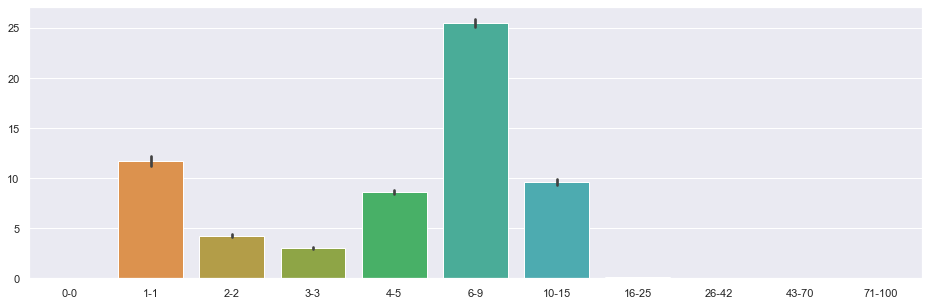

In [29]:
ax = sns.barplot(data=df[wpl_cols].rename(columns={col: col.replace('words_per_line_', '') for col in wpl_cols}))
ax.figure.set_size_inches(16,5)

In [30]:
wpl_few_cols = [col for col in wpl_cols if int(col.split('-')[-1]) <= 3]
wpl_many_cols = [col for col in wpl_cols if int(col.split('-')[-1]) > 3]
wpl_few_cols, wpl_many_cols

df['wpl_few'] = df[wpl_few_cols].sum(axis=1)
df['wpl_many'] = df[wpl_many_cols].sum(axis=1)


In [31]:
wpl_rel_df = df[['wpl_few', 'wpl_many']].div(df.lines, axis=0)
wpl_rel_df['lines'] = df.lines
wpl_rel_df

,wpl_few,wpl_many,lines
0,0.151515,0.848485,33
1,0.084746,0.915254,59
2,0.055556,0.944444,54
3,NaN,NaN,0
4,NaN,NaN,0
...,...,...,...
15852,0.195652,0.782609,46
15853,0.113636,0.886364,44
15854,0.113636,0.886364,44
15855,0.227273,0.772727,44


In [32]:
def classify_wpl_scan_type(row):
    if row['lines'] < 10:
        return 'partially_empty'
    elif row['wpl_few'] > 0.7:
        if row['lines'] > 100:
            return 'table'
        else:
            return 'list'
    elif row['wpl_few'] < 0.3:
        return 'running_text'
    else:
        return 'mixed'
    
    
wpl_rel_df['wpl_class'] = wpl_rel_df.apply(classify_wpl_scan_type, axis=1)
wpl_rel_df

,wpl_few,wpl_many,lines,wpl_class
0,0.151515,0.848485,33,running_text
1,0.084746,0.915254,59,running_text
2,0.055556,0.944444,54,running_text
3,NaN,NaN,0,partially_empty
4,NaN,NaN,0,partially_empty
...,...,...,...,...
15852,0.195652,0.782609,46,running_text
15853,0.113636,0.886364,44,running_text
15854,0.113636,0.886364,44,running_text
15855,0.227273,0.772727,44,running_text


In [33]:
wpl_rel_df.wpl_class.value_counts()

running_text       9739
mixed              2697
partially_empty    2390
list                523
table               508
Name: wpl_class, dtype: int64

## Grouping inventories by line categories

There are five categories of line widths. We can analyse scans by their composition of lines of different width categories.

In [34]:
lwr_cols = [col for col in df.columns if 'line_width_range_' in col]
df[lwr_cols]

,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
0,4,0,2,0,27
1,3,0,0,2,54
2,2,0,4,1,47
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
15852,6,0,3,1,35
15853,4,0,1,0,39
15854,4,1,4,2,33
15855,7,3,3,1,30


Many scans seem to have mostly lines wider than 1600 pixels, but some may have mainly short lines (e.g. scans with tables).

In [35]:
df.groupby('inv_num')['line_width_range_0-600'].describe().sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
inv_num,,,,,,,,
108A,3.0,1.333333,2.309401,0.0,0.00,0.0,2.00,4.0
946,4.0,2.250000,4.500000,0.0,0.00,0.0,2.25,9.0
37,3.0,0.666667,1.154701,0.0,0.00,0.0,1.00,2.0
47B,3.0,0.333333,0.577350,0.0,0.00,0.0,0.50,1.0
933,3.0,16.666667,28.867513,0.0,0.00,0.0,25.00,50.0
...,...,...,...,...,...,...,...,...
156,7.0,203.714286,138.431348,1.0,132.50,276.0,289.50,305.0
176,4.0,306.750000,354.915365,0.0,0.00,293.0,599.75,641.0
150,28.0,327.321429,141.682235,0.0,325.25,382.0,400.25,448.0


We can also aggregate the number of lines in each category per inventory and check if their median number of lines per scan differs.

In [37]:
g = df.groupby('inv_num')[lwr_cols].describe()#.sort_values('50%')
g.swaplevel(0, 1, axis=1)['50%']

,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
inv_num,,,,,
1,2.0,0.0,0.0,0.0,27.0
10,4.0,0.0,1.0,1.0,51.0
100,3.0,2.0,2.0,0.0,2.0
1005,13.0,1.0,3.0,7.5,42.5
1007,3.0,0.0,1.0,1.0,37.0
...,...,...,...,...,...
981,3.0,0.0,1.0,1.0,44.0
983,4.0,1.0,4.0,0.0,2.5
983A,7.0,1.0,2.0,1.0,3.0


Another steps is to turn the absolute frequencies into relative frequencies, so inventories are easier to compare.

In [38]:
g = df.groupby('inv_num')[lwr_cols + ['lines']].sum()
lwr_rel_df = g[lwr_cols].div(g.lines, axis=0)
lwr_rel_df['num_scans'] = s_inv_nums
lwr_rel_df

,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
1,0.061644,0.000000,0.041096,0.020548,0.876712,5
10,0.080519,0.007506,0.025247,0.016035,0.845786,53
100,0.510638,0.106383,0.234043,0.042553,0.106383,3
1005,0.224906,0.018868,0.089811,0.110189,0.550189,18
1007,0.041558,0.005195,0.041558,0.023377,0.875325,7
...,...,...,...,...,...,...
981,0.080645,0.016129,0.043011,0.032258,0.822581,5
983,0.268902,0.051762,0.356067,0.035485,0.276552,312
983A,0.561142,0.064548,0.098605,0.062601,0.178073,102


In [39]:
lwr_rel_df.sort_values('line_width_range_800-1300', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
1084,0.036145,0.000000,0.963855,0.000000,0.000000,3
1242,0.028944,0.013025,0.955137,0.000000,0.000000,11
887,0.053763,0.010753,0.935484,0.000000,0.000000,3
353,0.095556,0.004444,0.895556,0.000000,0.000000,9
1153,0.058696,0.013043,0.892391,0.001087,0.030435,19
108A,0.074074,0.037037,0.888889,0.000000,0.000000,3
886,0.000000,0.000000,0.884615,0.000000,0.076923,2
1243,0.099089,0.017084,0.882688,0.001139,0.000000,15
169,0.092527,0.021352,0.882562,0.000000,0.001779,12


In [40]:
line_cat_invs = lwr_rel_df.sort_values('line_width_range_800-1300', ascending=False).head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
1084,NL-HaNA_1.05.06_1084_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1084/file/NL-HaNA_1.05.06_1084_0001?eadId=1.05.06&unitID=1084
108A,NL-HaNA_1.05.06_108A_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/108A/file/NL-HaNA_1.05.06_108A_0001?eadId=1.05.06&unitID=108A
1153,NL-HaNA_1.05.06_1153_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1153/file/NL-HaNA_1.05.06_1153_0001?eadId=1.05.06&unitID=1153
1242,NL-HaNA_1.05.06_1242_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1242/file/NL-HaNA_1.05.06_1242_0001?eadId=1.05.06&unitID=1242
1243,NL-HaNA_1.05.06_1243_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1243/file/NL-HaNA_1.05.06_1243_0001?eadId=1.05.06&unitID=1243
169,NL-HaNA_1.05.06_169_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/169/file/NL-HaNA_1.05.06_169_0001?eadId=1.05.06&unitID=169
353,NL-HaNA_1.05.06_353_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/353/file/NL-HaNA_1.05.06_353_0001?eadId=1.05.06&unitID=353
886,NL-HaNA_1.05.06_886_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/886/file/NL-HaNA_1.05.06_886_0001?eadId=1.05.06&unitID=886
887,NL-HaNA_1.05.06_887_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/887/file/NL-HaNA_1.05.06_887_0001?eadId=1.05.06&unitID=887


All these books consist mainly of scans with a single text column on the right half of each page. Moreover, these books are all homogeneous in their line widths.

In [41]:
lwr_rel_df.sort_values('line_width_range_0-600', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
152,0.985079,0.004188,0.002356,0.001309,0.000785,13
114,0.979724,0.000922,0.002765,0.000000,0.002765,5
156,0.974710,0.012303,0.002051,0.000000,0.000000,7
954,0.974106,0.006165,0.007398,0.000000,0.001233,5
113,0.969639,0.011385,0.003795,0.000000,0.007590,5
1401,0.956772,0.020173,0.005764,0.000000,0.008646,3
150,0.954787,0.002917,0.002917,0.001667,0.000625,28
928,0.942973,0.022003,0.014818,0.000898,0.000449,13
220,0.937853,0.050847,0.000628,0.000000,0.001255,9


In [42]:
lwr_rel_df.sort_values('line_width_range_1300-1600', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
1220,0.074828,0.009166,0.028821,0.885775,0.000000,109
260,0.060261,0.004886,0.047231,0.884365,0.001629,8
1226,0.069069,0.015015,0.045045,0.867868,0.000000,5
1195,0.093750,0.025568,0.022727,0.852273,0.000000,5
24,0.135225,0.035058,0.013356,0.816361,0.000000,7
1193,0.137085,0.041126,0.019481,0.787157,0.012987,15
1197,0.181818,0.017408,0.017408,0.783366,0.000000,9
1148,0.086957,0.086957,0.000000,0.782609,0.043478,2
399,0.135965,0.028509,0.059211,0.774123,0.000000,7


In [43]:
line_cat_invs = lwr_rel_df.sort_values('line_width_range_1300-1600', ascending=False).head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
1148,NL-HaNA_1.05.06_1148_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1148/file/NL-HaNA_1.05.06_1148_0001?eadId=1.05.06&unitID=1148
1193,NL-HaNA_1.05.06_1193_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1193/file/NL-HaNA_1.05.06_1193_0001?eadId=1.05.06&unitID=1193
1195,NL-HaNA_1.05.06_1195_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1195/file/NL-HaNA_1.05.06_1195_0001?eadId=1.05.06&unitID=1195
1197,NL-HaNA_1.05.06_1197_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1197/file/NL-HaNA_1.05.06_1197_0001?eadId=1.05.06&unitID=1197
120,NL-HaNA_1.05.06_120_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/120/file/NL-HaNA_1.05.06_120_0001?eadId=1.05.06&unitID=120
1220,NL-HaNA_1.05.06_1220_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1220/file/NL-HaNA_1.05.06_1220_0001?eadId=1.05.06&unitID=1220
1226,NL-HaNA_1.05.06_1226_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1226/file/NL-HaNA_1.05.06_1226_0001?eadId=1.05.06&unitID=1226
24,NL-HaNA_1.05.06_24_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/24/file/NL-HaNA_1.05.06_24_0001?eadId=1.05.06&unitID=24
260,NL-HaNA_1.05.06_260_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/260/file/NL-HaNA_1.05.06_260_0001?eadId=1.05.06&unitID=260


In [44]:
lwr_rel_df.sort_values('line_width_range_600-800', ascending=False).head(10)



,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,num_scans
inv_num,,,,,,
315,0.090909,0.272727,0.363636,0.181818,0.090909,3
109,0.200000,0.233333,0.066667,0.066667,0.433333,3
1367,0.111111,0.222222,0.111111,0.000000,0.555556,2
314,0.419890,0.220994,0.243094,0.044199,0.071823,5
1151,0.237557,0.205882,0.190045,0.031674,0.332579,9
387A,0.162162,0.189189,0.567568,0.081081,0.000000,3
1402,0.753012,0.186747,0.054217,0.000000,0.004016,5
1366,0.571429,0.171429,0.257143,0.000000,0.000000,2
1365,0.083333,0.166667,0.083333,0.000000,0.666667,2


In [45]:
line_cat_invs = lwr_rel_df.sort_values('line_width_range_600-800', ascending=False).head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
109,NL-HaNA_1.05.06_109_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/109/file/NL-HaNA_1.05.06_109_0001?eadId=1.05.06&unitID=109
1151,NL-HaNA_1.05.06_1151_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1151/file/NL-HaNA_1.05.06_1151_0001?eadId=1.05.06&unitID=1151
1365,NL-HaNA_1.05.06_1365_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1365/file/NL-HaNA_1.05.06_1365_0001?eadId=1.05.06&unitID=1365
1366,NL-HaNA_1.05.06_1366_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1366/file/NL-HaNA_1.05.06_1366_0001?eadId=1.05.06&unitID=1366
1367,NL-HaNA_1.05.06_1367_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1367/file/NL-HaNA_1.05.06_1367_0001?eadId=1.05.06&unitID=1367
1402,NL-HaNA_1.05.06_1402_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1402/file/NL-HaNA_1.05.06_1402_0001?eadId=1.05.06&unitID=1402
305,NL-HaNA_1.05.06_305_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/305/file/NL-HaNA_1.05.06_305_0001?eadId=1.05.06&unitID=305
314,NL-HaNA_1.05.06_314_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/314/file/NL-HaNA_1.05.06_314_0001?eadId=1.05.06&unitID=314
315,NL-HaNA_1.05.06_315_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/315/file/NL-HaNA_1.05.06_315_0001?eadId=1.05.06&unitID=315


#### Heterogeneous line widths

If we represent inventories by the line width category with the maximum fraction, and then sort inventories by the lowest maximum fraction, we get a list of inventories that are most diverse in terms of line width.

In [46]:
lwr_rel_df[lwr_cols].max(axis=1).sort_values().head(10)

inv_num
262     0.283019
690     0.306094
1342    0.314286
40      0.319568
708     0.325000
43      0.325301
1151    0.332579
1378    0.333333
1397    0.338583
481     0.344519
dtype: float64

In [47]:
line_cat_invs = lwr_rel_df[lwr_cols].max(axis=1).sort_values().head(10).index

(df[df.inv_num.isin(line_cat_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'num_scans', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,num_scans,iiif_url
inv_num,,,
1151,NL-HaNA_1.05.06_1151_0001.jpg,9,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1151/file/NL-HaNA_1.05.06_1151_0001?eadId=1.05.06&unitID=1151
1342,NL-HaNA_1.05.06_1342_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1342/file/NL-HaNA_1.05.06_1342_0001?eadId=1.05.06&unitID=1342
1378,NL-HaNA_1.05.06_1378_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1378/file/NL-HaNA_1.05.06_1378_0001?eadId=1.05.06&unitID=1378
1397,NL-HaNA_1.05.06_1397_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1397/file/NL-HaNA_1.05.06_1397_0001?eadId=1.05.06&unitID=1397
262,NL-HaNA_1.05.06_262_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/262/file/NL-HaNA_1.05.06_262_0001?eadId=1.05.06&unitID=262
40,NL-HaNA_1.05.06_40_0001.jpg,146,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/40/file/NL-HaNA_1.05.06_40_0001?eadId=1.05.06&unitID=40
43,NL-HaNA_1.05.06_43_0001.jpg,3,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/43/file/NL-HaNA_1.05.06_43_0001?eadId=1.05.06&unitID=43
481,NL-HaNA_1.05.06_481_0001.jpg,21,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/481/file/NL-HaNA_1.05.06_481_0001?eadId=1.05.06&unitID=481
690,NL-HaNA_1.05.06_690_0001.jpg,23,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/690/file/NL-HaNA_1.05.06_690_0001?eadId=1.05.06&unitID=690


We can also analyse the distribution of line widths across scans and check what the maximum fraction is. This shows how homogeneous the line widths of a scan are.

In [62]:
df[lwr_cols].div(df.lines, axis=0).max(axis=1)

0        0.818182
1        0.915254
2        0.870370
3             NaN
4             NaN
           ...   
15852    0.760870
15853    0.886364
15854    0.750000
15855    0.681818
15856    0.518519
Length: 15857, dtype: float64

The above shows that in the first scan, the line width category with the highest fraction represents 82% of the lines. **In other words, this scans is fairly homogeneous in terms of line widths.**

If we plot the distribution of these maximum fractions, we can see how homogeneous or heterogeneous scans in this archive are.

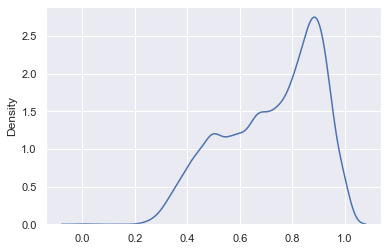

In [64]:
sns.kdeplot(data=df[lwr_cols].div(df.lines, axis=0).max(axis=1));

This shows that many scans are homogeneous (over 80% of lines are in the same line width category), but also a large chunk of scans are more heterogeneous in line widths.